In [1]:
from datetime import date
from nsepy import get_history
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
data = get_history(symbol='TATAMOTORS',
                   start=date(2021,9,1),
                   end=date(2021,12,1))['Close']



Date
2021-12-02    479.1
2021-12-03    480.1
2021-12-06    467.2
Name: Close, dtype: float64

In [3]:
data
df_tatamotors= pd.DataFrame(data)
df_tatamotors = df_tatamotors.asfreq('b')   # < -- setting b (business days) 
                                        #avoids unnecessary time periods
    
df_tatamotors

,Close
Date,
2021-09-01,295.25
2021-09-02,293.15
2021-09-03,295.55
2021-09-06,297.45
2021-09-07,294.60
...,...
2021-11-25,492.75
2021-11-26,460.20
2021-11-29,461.45


In [4]:
df_tatamotors.isna().sum()

Close    4
dtype: int64

In [5]:
df_tatamotors = df_tatamotors.dropna()

In [6]:
df_tatamotors['Close']

Date
2021-09-01    295.25
2021-09-02    293.15
2021-09-03    295.55
2021-09-06    297.45
2021-09-07    294.60
               ...  
2021-11-25    492.75
2021-11-26    460.20
2021-11-29    461.45
2021-11-30    458.60
2021-12-01    475.25
Name: Close, Length: 62, dtype: float64

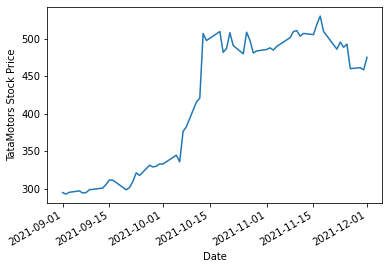

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting Tatamotors stock

ax = df_tatamotors['Close'].plot()
ax.set_ylabel('TataMotors Stock Price')
plt.show()

In [8]:
#Stationarity and the ADF Test

from statsmodels.tsa.stattools import adfuller
result = adfuller(df_tatamotors['Close'])
result

(-1.2027343857864952,
 0.6724183434670685,
 0,
 61,
 {'1%': -3.542412746661615,
  '5%': -2.910236235808284,
  '10%': -2.5927445767266866},
 433.1292691248326)

In [9]:
p_value = result[1]

#Check stationarity
if p_value < 0.05 :
    print('Series is Stationary')
else :
    print('Series is not Stationary')

Series is not Stationary


In [10]:
#Perform differencing as the series is not stationary

differenced_data = df_tatamotors.diff(periods=1).dropna()
differenced_data

,Close
Date,
2021-09-02,-2.10
2021-09-03,2.40
2021-09-06,1.90
2021-09-07,-2.85
2021-09-08,0.65
...,...
2021-11-25,4.10
2021-11-26,-32.55
2021-11-29,1.25


In [11]:
differenced_data['Close']

Date
2021-09-02    -2.10
2021-09-03     2.40
2021-09-06     1.90
2021-09-07    -2.85
2021-09-08     0.65
              ...  
2021-11-25     4.10
2021-11-26   -32.55
2021-11-29     1.25
2021-11-30    -2.85
2021-12-01    16.65
Name: Close, Length: 61, dtype: float64

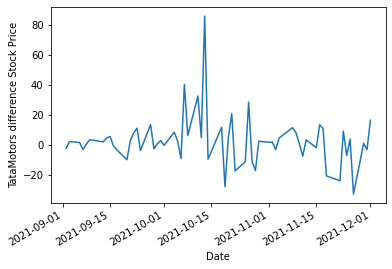

In [12]:
# Plotting Tatamotors stock

ax = differenced_data['Close'].plot()
ax.set_ylabel('TataMotors difference Stock Price')
plt.show()

In [13]:
#Check for stationarity

result = adfuller(differenced_data['Close'])
p_value = result[1]

print(result)

#Check stationarity
if p_value < 0.05 :
    print('Series is Stationary')
else :
    print('Series is not Stationary')

(-8.416332025232206, 2.0390030488341028e-13, 0, 60, {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}, 427.1214924041061)
Series is Stationary


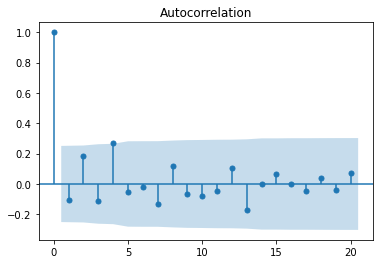

In [14]:
#Lags ACF
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(differenced_data['Close'],lags=20)  
                                    
plt.show()

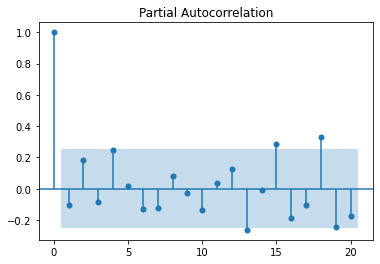

In [15]:
#PACF

from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(differenced_data['Close'],lags=20) 
                                    
plt.show()

In [16]:
from sklearn.metrics import r2_score
from statsmodels.regression.linear_model import yule_walker

def evaluate(order):
    
    #take last ten years of data for test set
    train = list(differenced_data['Close'])[:-10]
    test = list(differenced_data['Close'])[-10:]
    
    coeffs,sigma = yule_walker(train, order = order )
    #print('Coefficients: ', -coeffs)
    #print('Sigma: ', sigma)
    
    # Make a list of differenced values
    val_list = list(train)
    val_list

    # Reverse the list so that the order corresponds with the order of the coefficients
    val_list.reverse()  #performs inplace list reversal

    #Define the number of years to predict
    n_steps = 10
    # for each year to predict
    for i in range(n_steps):
        #print('i = ',i)
   
        #Compute the new value as the sum of lagged values multiplied by their corresponding coeffs
        new_val = 0
        #print(' New val = ', new_val)
        for j in range(len(coeffs)):
            new_val += coeffs[j] * val_list[j]
            #print(' After computation = ', new_val)
        
        #Insert the new value at the beginning of the list
        val_list.insert(0, new_val)
        #print('final new val', new_val)
    
    #reverse to have the order of time
    val_list.reverse()

    #Add the orignal first value back into the lost and do a cumulative sum to undo the differencing
    val_list = [df_tatamotors['Close'].values[0]] + val_list

    new_val_list = pd.Series(val_list).cumsum()
    
    #plot the newly obtained list

    validation = pd.DataFrame(
    {
        'original':df_tatamotors['Close'].reset_index(drop='True'),
        'prediction':new_val_list
    })
    
    return r2_score(validation.iloc[-10:,0],validation.iloc[-10:,1])
    

In [17]:
# For each order between 1 to 31, fit and evaluate the model

orders = []
r2scores=[]

for order in range(1 ,31):
    orders.append(order)
    r2scores.append(evaluate(order))
    
#create  a result dataframe
results = pd.DataFrame(
{
    'orders': orders,
    'r2scores':r2scores
})

results

,orders,r2scores
0,1,-2.061730
1,2,-2.414731
2,3,-2.309808
3,4,-2.540031
4,5,-2.521514
5,6,-2.168779
6,7,-1.777539
7,8,-2.616753
8,9,-2.774631
9,10,-2.129474


In [18]:
#show the order with best R2 score
filt_cond = results.max()['r2scores']
results[results['r2scores'] == filt_cond]

,orders,r2scores
24,25,0.313226


In [27]:
#Now fitting to AR(13) model
#take last ten years of data for test set

#take last ten years of data for test set
train = list(differenced_data['Close'])[:-10]
test = list(differenced_data['Close'])[-10:]
    
coeffs,sigma = yule_walker(train, order = 25 )
print('Coefficients: ', -coeffs)
print('Sigma: ', sigma)
    
# Make a list of differenced values
val_list = list(train)
val_list

# Reverse the list so that the order corresponds with the order of the coefficients
val_list.reverse()  #performs inplace list reversal

#Define the number of years to predict
n_steps = 20
# for each year to predict
for i in range(n_steps):
    #print('i = ',i)   
    #Compute the new value as the sum of lagged values multiplied by their corresponding coeffs
     new_val = 0
     #print(' New val = ', new_val)
     for j in range(len(coeffs)):
        new_val += coeffs[j] * val_list[j]
        #print(' After computation = ', new_val)
        
     #Insert the new value at the beginning of the list
     val_list.insert(0, new_val)
     #print('final new val', new_val)
    
 #reverse to have the order of time
val_list.reverse()

#Add the orignal first value back into the lost and do a cumulative sum to undo the differencing
val_list = [df_tatamotors['Close'].values[0]] + val_list

new_val_list = pd.Series(val_list).cumsum()
    
#plot the newly obtained list

validation = pd.DataFrame(
{
  'original':df_tatamotors['Close'].reset_index(drop='True'),
  'prediction':new_val_list
})

Coefficients:  [ 1.07248186e-01 -3.88480028e-01  2.30862271e-01  1.63235344e-02
 -5.88095513e-02  3.47212328e-01  2.36552905e-01 -3.14827100e-01
 -2.52337674e-02  5.20823856e-01  2.01227618e-02 -2.62508991e-01
  4.73373036e-01  1.49516969e-01 -3.14039530e-01  2.53784932e-01
  1.86534008e-01 -9.06012667e-02  2.55436994e-01  1.39604812e-01
 -9.58611748e-02 -7.06492461e-02  2.62865288e-01  2.52780208e-01
  3.84671280e-05]
Sigma:  11.305241246941945


In [28]:
validation.tail(20)

,original,prediction
52,530.15,517.341294
53,509.70,490.071151
54,486.10,481.592918
55,495.50,486.276450
56,488.65,486.695362
57,492.75,475.685852
58,460.20,476.475300
59,461.45,490.387462
60,458.60,493.471976
61,475.25,479.756806


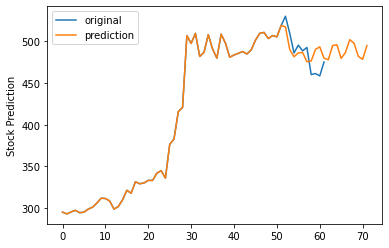

In [29]:
#print('Test R2:', r2_score(validation.iloc[-10:,0],validation.iloc[-10:,1]))

#plot newly obtained list
plt.plot(validation)
plt.legend(validation.columns)
plt.ylabel('Stock Prediction')
plt.show()

In [30]:
df_tatamotors.tail(10)

,Close
Date,
2021-11-17,530.15
2021-11-18,509.70
2021-11-22,486.10
2021-11-23,495.50
2021-11-24,488.65
2021-11-25,492.75
2021-11-26,460.20
2021-11-29,461.45
2021-11-30,458.60


In [23]:
check = get_history(symbol='TATAMOTORS',
                   start=date(2021,12,2),
                   end=date(2021,12,6))['Close']

check

Date
2021-12-02    479.1
2021-12-03    480.1
2021-12-06    467.2
Name: Close, dtype: float64

In [34]:
validation.tail(11)

,original,prediction
61,475.25,479.756806
62,NaN,478.008831
63,NaN,495.031934
64,NaN,495.899715
65,NaN,479.589373
66,NaN,486.806831
67,NaN,502.042543
68,NaN,497.796139
69,NaN,482.000672
70,NaN,478.454105
